## Phase 4.41 - 4.42

# Tensorflow, Deep Neural Networks

## Objectives
- Get some <a href='#background'>background</a> in Tensorflow, Keras (and PyTorch).
- Look at <a href='#tensors'>Tensors</a> and how they're used.
- Start working in <a href='#tensorflow'>Tensorflow</a>!
    - <a href='#preprocessing'>Processing Data</a>.
    - Various methods of <a href='#tuning'>building and tuning a Model</a>.

# Tensorflow / Keras
<a id='background'></a>
## Background

- Keras is an API coded in Python.
- There are three systems built on the Keras API: *Tensorflow*, *Theano*, *CNTK*.
    - *Theano has been discontinued. The last release was 2017, but can still be used.*
- Keras development is backed primarily by Google, and the Keras API comes packaged in TensorFlow as tf.keras.
- **We will use TensorFlow**, as it is the most popular. TensorFlow became the most used Keras backend, and eventually integrated Keras into via the tf.keras submodule of TensorFlow.


> *PyTorch is the leading competitor to Tensorflow based on interest and usage.*
>
> *Many higher education institutions are teaching deep learning via PyTorch. Although not at all necessary to know both, I would recommend to keep PyTorch in your mind and perhaps add to your repertoire as a Data Scientist.*

<a id='tensors'></a>
# Tensors
<img src='./images/tensors.png' width=600>

> **Left:** A "Column"
>
> **Middle:** A "DataFrame"
>
> **Right:** A "multi-dimensional DataFrame". *Most commonly images.*

## Tensors as *Images*

- A Black and White image can be represented as a tensor of shape *$\large (m, n)$* where coordinate $\large (m_i, n_i)$ points to a *pixel*.
<img src='./images/bw_pixel.jpeg' width=300>

- A Color image (rgb) can be represented as a tensor of shape *$\large (m, n, 3)$* where a coordinate $\large (m_i, n_i, r)$ would point to a pixel in layer $\large r$ and $\large (m_i, n_i, b)$ would point to a pixel in layer $\large b$.
<img src='./images/rgb_example.png'>

## Tensors as *Game-States*

> - **AlphaZero**, Google's Reinforcement Learning Neural Network was trained to play games (Go, Chess, Shogi, Starcraft II, others). 
> - This is a two-part model:
    1. A Neural Network and 
    2. a Monte Carlo Tree Search algorithm.
    
    
- 3-dimensional tensors are used as an input and output for the neural network.


- Input is a tensor of shape *$\large (N, N, (MT + L))$*.
    - $N x N$ represents the shape of the board.
        - (8, 8) for chess: *[1-8, a-h]*.
    - $T$ represents a *time-step* for the game.
        - The previous 8-game positions are stored and fed as an input.
    - $M$ represents a binary representation of the presence of the player's pieces on the board, one for each piece-type.
        - 6 piece-types for chess: Pawn, Knight, Bishop, Rook, Queen, King
    - $L$ represents a number of constant-vaues input plantes, denoting aspects of the game-state.
        - Player's color, total move count, special rules (castling, repetition count for that specific position, number of moves "without progress").

<img src='./images/alphazero_input.png' width=500>

#### Fun Facts:
> Match Results: Google's Deep Mind project **AlphaZero** vs reigning WCCC Champion **Stockfish**.
>
> | Game | White | Black | Win | Draw | Loss |
> | ---- | ----- | ----- | --- | ---- | ---- |
> | Chess | AlphaZero | Stockfish | 25 | 25 | 0
> | Chess | Stockfish | AlphaZero | 3 | 47 | 0
>
> - *Stockfish "calculates" 60, 000, 000 positions per second. AlphaZero "calculates" 60, 000 positions per second.*
> - *AlphaZero was trained on 9-hours of training ("self-play").*
>
> Additional Resources and Information:
> <a href='https://arxiv.org/abs/1712.01815'>Mastering Chess and Shogi [...]</a>

<a id='tensorflow'></a>
# Working with Tensorflow

**In this example, we want to be using *DataFrame-shaped* Tensors** $(m, n)$.
*In order to do this, we will want **each row to represent an entire image** and each column to represent a pixel.*

*We will talk about CNNs next - where each row is an entire image, but is **not** flattened first.* 
- E.g.: An input could be represented in shape $(1000, 64, 64, 3)$.*
```
DataShape = (
    {number of images = 1000}, 
    {number of rows (pixels) = 64}, 
    {number of columns (pixels) = 64}, 
    {number of planes (rgb) = 3}
)
```

## Loading Data

In [1]:
import keras
import tensorflow as tf
from tensorflow.keras import layers, Sequential

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
X = digits.images
y = digits.target

In [4]:
X.shape

(1797, 8, 8)

In [5]:
y.shape

(1797,)

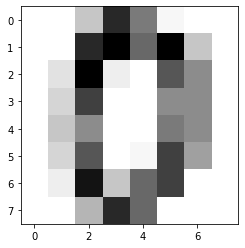

In [6]:
plt.imshow(X[0], cmap='Greys');

In [7]:
digits['data'][0].shape

(64,)

<a id='preprocessing'></a>
## Preprocessing
- Flatten each image into a row of data.
    - Alternatively, with this example, we could just use `data`.
- Train-test-split into Train, Test, Validation
    - Sizes: (0.7, 0.15, 0.15)
- Scale data to a value [0-1] (pixel intensity)


- One Hot Encode our target.

### Flattening Images

In [8]:
X[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [9]:
# Already a numpy array.
X[0].reshape(-1,)

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [10]:
X_flat = X.reshape(X.shape[0], -1)
X_flat.shape

(1797, 64)

In [11]:
# # Alternate method without using .reshape
# X_flat = np.array([x.reshape(-1,) for x in X])

In [12]:
# Sanity Check
all(digits['data'][0] == X_flat[0])

True

### Target Processing: OneHotEncoder

- Differently from scikit-learn models, Tensorflow multiclass classification models' predictions are an array (a OneHotEncoded version of a multiclass variable).
- Since we are encoding only our target (and we want this representation consistent) we can perform this before the train-test-split.

In [13]:
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.reshape(-1, 1))

In [14]:
y_ohe.shape

(1797, 10)

In [15]:
ohe.categories_

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]

### Train Test Split
*My go-to train/test/val size is (0.7, 0.15, 0.15), but there is no hard and fast rule on this.*

In [16]:
SEED = 51
TEST_SIZE = int(X_flat.shape[0] * 0.15)

# Number of samples for Test and Val
TEST_SIZE

269

In [17]:
# Split out Test data first.
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_ohe, test_size=TEST_SIZE, random_state=SEED)

# Split Val from training data.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=SEED)

# Sanity check.
print(f'Train:\n\tX: {X_train.shape}\n\ty: {y_train.shape}')
print(f'Test:\n\tX: {X_test.shape}\n\ty: {y_test.shape}')
print(f'Val:\n\tX: {X_val.shape}\n\ty: {y_val.shape}')

Train:
	X: (1259, 64)
	y: (1259, 10)
Test:
	X: (269, 64)
	y: (269, 10)
Val:
	X: (269, 64)
	y: (269, 10)


### Scaling Data

In [18]:
# Check the max values in each image array.
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(16.0, 16.0, 16.0)

*Since pixel data exists with constraints (255 is the maximum value for most images, 16 is the maximum value here), there is no worry of data leakage between data sets.*

In [19]:
# Scaling data.
X_train, X_test, X_val = X_train / 16, X_test / 16, X_val / 16

In [20]:
# Sanity check.
(max([x for img in X_train for x in img]),
 max([x for img in X_test for x in img]),
 max([x for img in X_val for x in img]))

(1.0, 1.0, 1.0)

## Building a Model

- FFNN (Forward-Feed Neural Networks) are named for the way they proceed sequentially through their layers.
- For today, we will only look at this model type.
- In Tensorflow they are part of a class `Sequential`.

In [21]:
# Starting model construction.
model = Sequential()

In [22]:
# Adding an input layer.
model.add(
    layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1])
    )

In [23]:
# Adding an output layer.
model.add(
    layers.Dense(units=10, activation='softmax')
    )

- Lastly, we have to define a loss function, a metric, and an optimizer.

- Optimizers are functions which update our weights in smart ways instead of treating all parameters equaly. Adam, a popular optimizer, calculates an individual learning rate for each parameter.

In [24]:
# Compile model with an optimizer, loss function, and preferred metrics.
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

In [25]:
# Show model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 260       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


## Fitting / Predicting

In [26]:
# Fit
model.fit(X_train, y_train)

40/40 [==============================] - 0s 826us/step - loss: 2.3785 - accuracy: 0.0885


In [27]:
# Predict
model.predict(X_test[[0]])

array([[0.09930561, 0.10056257, 0.10030611, 0.10015744, 0.09996217,
        0.100457  , 0.09933072, 0.09991094, 0.09955138, 0.10045608]],
      dtype=float32)

In [28]:
# Predict class
np.argmax(model.predict(X_test[[0]]), axis=-1)

array([1])

In [29]:
predictions_df = pd.DataFrame(
    zip(ohe.categories_[0], model.predict(X_test[[0]])[0]),
    columns=['Target', 'Softmax']
    )
predictions_df

,Target,Softmax
0,0,0.099306
1,1,0.100563
2,2,0.100306
3,3,0.100157
4,4,0.099962
5,5,0.100457
6,6,0.099331
7,7,0.099911
8,8,0.099551
9,9,0.100456


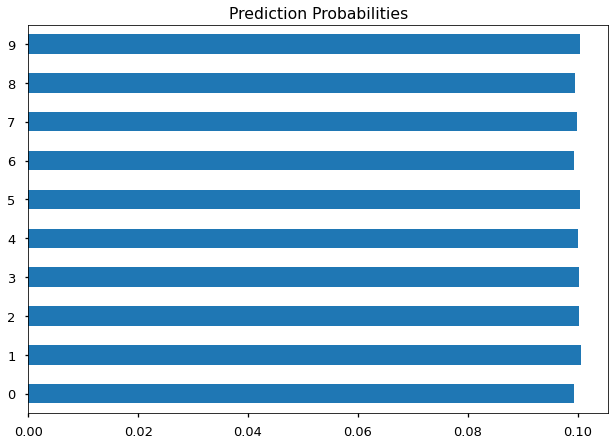

In [30]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots()
    predictions_df['Softmax'].plot(kind='barh')
    ax.set(title='Prediction Probabilities')

In [31]:
# Functionalizing the above.
def plot_prediction_probabilities(trained_model, encoder, entry):
    """
    Show a bar chart representing prediction probabilities.
    """
    
    predictions_df = pd.DataFrame(
        zip(encoder.categories_[0], trained_model.predict(entry)[0]),
        columns=['Target', 'Softmax']
        )
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots()
        predictions_df['Softmax'].plot(kind='barh')
        ax.set(title='Prediction Probabilities')
        plt.show()

## Incorporating Validation Data

In [32]:
# Add validation data.
model.fit(X_train, y_train, validation_data=(X_val, y_val))

40/40 [==============================] - 1s 19ms/step - loss: 2.2932 - accuracy: 0.1215 - val_loss: 2.2866 - val_accuracy: 0.0967


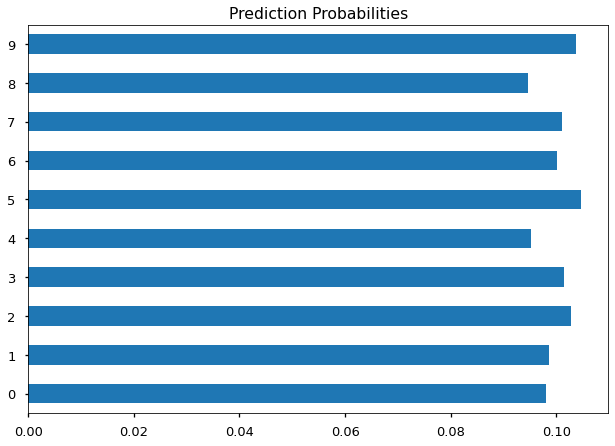

In [33]:
plot_prediction_probabilities(model, ohe, X_train[[0]])

## Add Epochs

In [34]:
# Save the model fit to a variable. Training info is stored here.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
40/40 [==============================] - 0s 6ms/step - loss: 2.2435 - accuracy: 0.1263 - val_loss: 2.2300 - val_accuracy: 0.1152
Epoch 2/5
40/40 [==============================] - 0s 2ms/step - loss: 2.1804 - accuracy: 0.1525 - val_loss: 2.1545 - val_accuracy: 0.2082
Epoch 3/5
40/40 [==============================] - 0s 2ms/step - loss: 2.0858 - accuracy: 0.2288 - val_loss: 2.0416 - val_accuracy: 0.2565
Epoch 4/5
40/40 [==============================] - 0s 2ms/step - loss: 1.9795 - accuracy: 0.2931 - val_loss: 1.9293 - val_accuracy: 0.3011
Epoch 5/5
40/40 [==============================] - 0s 2ms/step - loss: 1.8819 - accuracy: 0.3177 - val_loss: 1.8318 - val_accuracy: 0.3457


In [35]:
history

In [36]:
history.history

{'loss': [2.2435390949249268,
  2.180361747741699,
  2.0857808589935303,
  1.9795324802398682,
  1.881899118423462],
 'accuracy': [0.1262907087802887,
  0.15250198543071747,
  0.2287529855966568,
  0.29308974742889404,
  0.3177124559879303],
 'val_loss': [2.230025053024292,
  2.1545286178588867,
  2.0415725708007812,
  1.9293107986450195,
  1.8318361043930054],
 'val_accuracy': [0.115241639316082,
  0.20817844569683075,
  0.2565055787563324,
  0.3011152446269989,
  0.3457249104976654]}

In [37]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

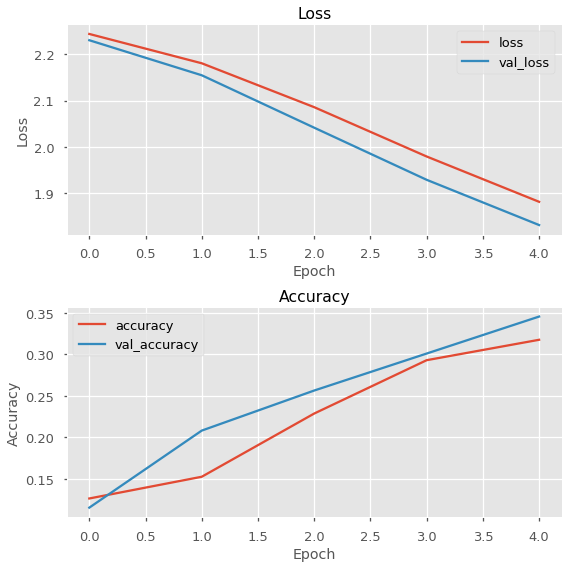

In [38]:
plot_history(history)

In [39]:
# Adding more epochs!
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
40/40 [==============================] - 0s 3ms/step - loss: 1.7934 - accuracy: 0.3511 - val_loss: 1.7437 - val_accuracy: 0.3941
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 1.7101 - accuracy: 0.4369 - val_loss: 1.6614 - val_accuracy: 0.4907
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 1.6302 - accuracy: 0.5036 - val_loss: 1.5836 - val_accuracy: 0.5428
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 1.5539 - accuracy: 0.5290 - val_loss: 1.5122 - val_accuracy: 0.5576
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 1.4818 - accuracy: 0.5473 - val_loss: 1.4429 - val_accuracy: 0.5725
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 1.4126 - accuracy: 0.5687 - val_loss: 1.3773 - val_accuracy: 0.5762
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 1.3462 - accuracy: 0.5862 - val_loss: 1.3140 - val_accuracy: 0.5911
Epoch 8/10
40/40 [==

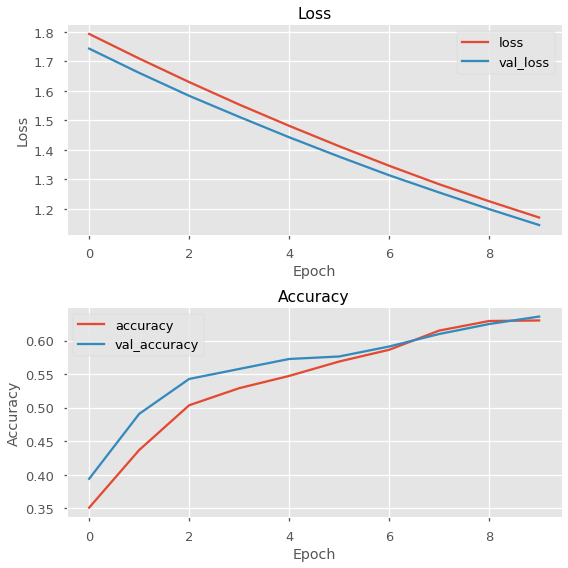

In [40]:
plot_history(history)

## Add Layers
There are no hard set rules for building neural networks. It is an empirical process, where one tries different architectures and see what works. However, it is a good idea to try out deep networks, since we know that successive layers find increasingly complex patterns.

In [41]:
# Building a new model with a hidden layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                70        
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
40/40 [==============================] - 1s 5ms/step - loss: 2.2715 - accuracy: 0.1720 - val_loss: 2.2471 - val_accuracy: 0.2342
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 2.2423 - accuracy: 0.2014 - val_loss: 2.2084 - val_accuracy: 0.2342
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 2.1982 - accuracy: 0.1982 - val_loss: 2.1690 - val_accuracy: 0.2379
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 2.1559 - accuracy: 0.2135 - val_loss: 2.1232 - val_accuracy: 0.2565
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 2.1222 - accuracy: 0.2304 - val_loss: 2.0731 - val_accuracy: 0.2639
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 2.0639 - accuracy: 0.2333 - val_loss: 2.0196 - val_accuracy: 0.2825
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 2.0284 - accuracy: 0.2689 - val_loss: 1.9520 - val_accuracy: 0.2714
Epoch 8/10
40/40 [==

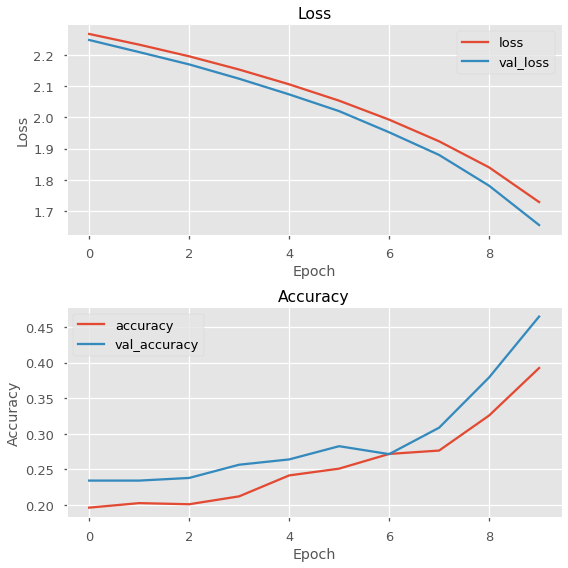

In [43]:
plot_history(history)

In [44]:
# Adding one more layer.
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
Total params: 470
Trainable params: 470
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
40/40 [==============================] - 1s 8ms/step - loss: 2.2889 - accuracy: 0.2193 - val_loss: 2.2544 - val_accuracy: 0.1859
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 2.2462 - accuracy: 0.1979 - val_loss: 2.2039 - val_accuracy: 0.2416
Epoch 3/10
40/40 [==============================] - 0s 2ms/step - loss: 2.1996 - accuracy: 0.2230 - val_loss: 2.1368 - val_accuracy: 0.2714
Epoch 4/10
40/40 [==============================] - 0s 2ms/step - loss: 2.1452 - accuracy: 0.2307 - val_loss: 2.0589 - val_accuracy: 0.2454
Epoch 5/10
40/40 [==============================] - 0s 2ms/step - loss: 2.0766 - accuracy: 0.2136 - val_loss: 1.9810 - val_accuracy: 0.2491
Epoch 6/10
40/40 [==============================] - 0s 2ms/step - loss: 1.9893 - accuracy: 0.2317 - val_loss: 1.9097 - val_accuracy: 0.2565
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 1.9409 - accuracy: 0.2336 - val_loss: 1.8342 - val_accuracy: 0.2677
Epoch 8/10
40/40 [==

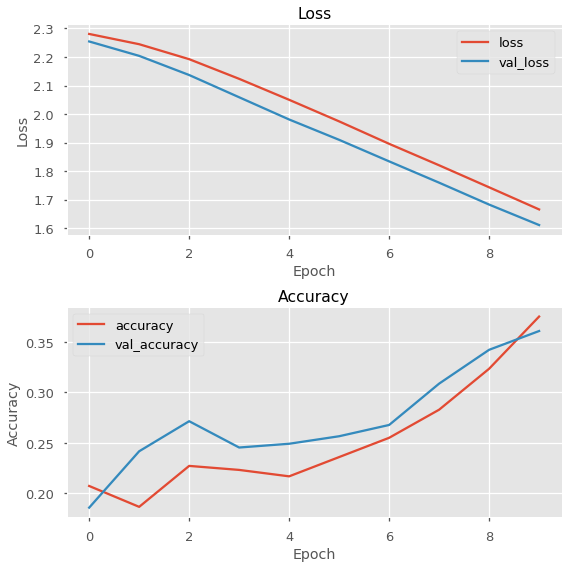

In [46]:
plot_history(history)

## Change Batch Size
By default, we use *batch gradient descent*. We can change this by altering the `batch_size` parameter.

### Mini-Batch

In [47]:
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [48]:
X_train.shape[0]

1259

In [49]:
# Full-batch.
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10,
    batch_size=X_train.shape[0]
    )

Epoch 1/10
1/1 [==============================] - 1s 554ms/step - loss: 2.3514 - accuracy: 0.1080 - val_loss: 2.3310 - val_accuracy: 0.1041
Epoch 2/10
1/1 [==============================] - 0s 40ms/step - loss: 2.3451 - accuracy: 0.1080 - val_loss: 2.3258 - val_accuracy: 0.1041
Epoch 3/10
1/1 [==============================] - 0s 43ms/step - loss: 2.3392 - accuracy: 0.1080 - val_loss: 2.3210 - val_accuracy: 0.1041
Epoch 4/10
1/1 [==============================] - 0s 47ms/step - loss: 2.3338 - accuracy: 0.1080 - val_loss: 2.3166 - val_accuracy: 0.1041
Epoch 5/10
1/1 [==============================] - 0s 46ms/step - loss: 2.3286 - accuracy: 0.1080 - val_loss: 2.3124 - val_accuracy: 0.1041
Epoch 6/10
1/1 [==============================] - 0s 46ms/step - loss: 2.3239 - accuracy: 0.1080 - val_loss: 2.3085 - val_accuracy: 0.1078
Epoch 7/10
1/1 [==============================] - 0s 45ms/step - loss: 2.3195 - accuracy: 0.1080 - val_loss: 2.3050 - val_accuracy: 0.1078
Epoch 8/10
1/1 [==========

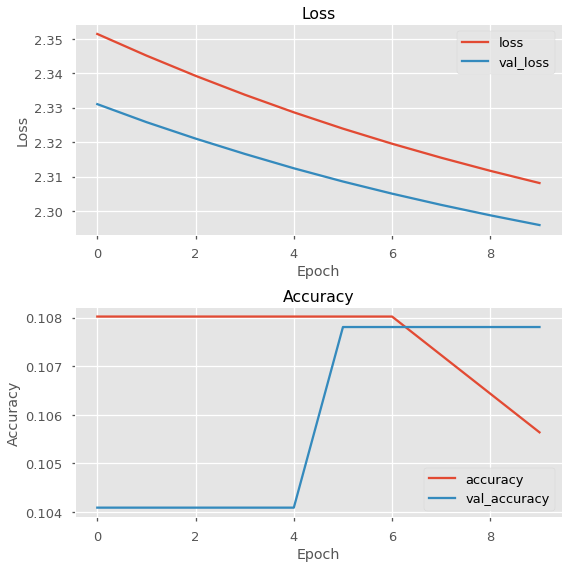

In [50]:
plot_history(history)

### Stochastic Gradient Descent

In [51]:
model = Sequential()
model.add(layers.Dense(units=4, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(units=6, activation='relu'))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="RMSProp", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [52]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10,
    batch_size=1
    )

Epoch 1/10
1259/1259 [==============================] - 2s 950us/step - loss: 2.2435 - accuracy: 0.1379 - val_loss: 1.7954 - val_accuracy: 0.3271
Epoch 2/10
1259/1259 [==============================] - 1s 770us/step - loss: 1.6204 - accuracy: 0.4126 - val_loss: 1.2873 - val_accuracy: 0.5502
Epoch 3/10
1259/1259 [==============================] - 1s 782us/step - loss: 1.2197 - accuracy: 0.5503 - val_loss: 1.0362 - val_accuracy: 0.6617
Epoch 4/10
1259/1259 [==============================] - 1s 920us/step - loss: 0.9757 - accuracy: 0.6607 - val_loss: 0.8976 - val_accuracy: 0.6989
Epoch 5/10
1259/1259 [==============================] - 1s 816us/step - loss: 0.8012 - accuracy: 0.7499 - val_loss: 0.7886 - val_accuracy: 0.7398
Epoch 6/10
1259/1259 [==============================] - 1s 791us/step - loss: 0.6848 - accuracy: 0.8063 - val_loss: 0.6823 - val_accuracy: 0.7881
Epoch 7/10
1259/1259 [==============================] - 1s 823us/step - loss: 0.6404 - accuracy: 0.8140 - val_loss: 0.6899 -

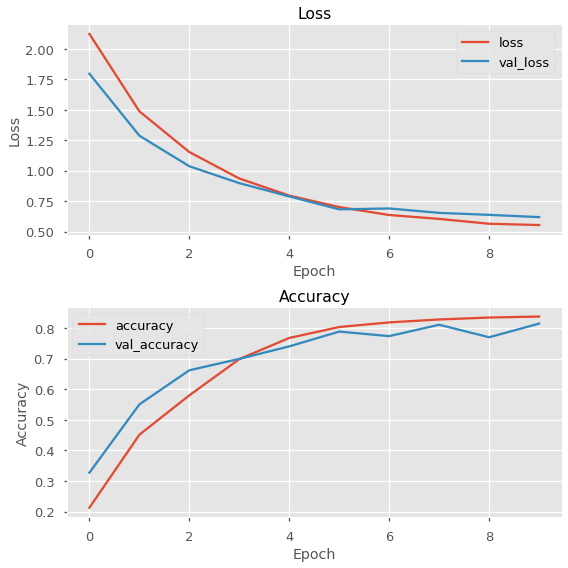

In [53]:
plot_history(history)

<a id='tuning'></a>
# Baseline Model - Before Tuning

In [54]:
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))

model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                90        
Total params: 6,994
Trainable params: 6,994
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.2750 - accuracy: 0.1930 - val_loss: 2.1806 - val_accuracy: 0.2305
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0719 - accuracy: 0.2864 - val_loss: 1.9422 - val_accuracy: 0.2528
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.8093 - accuracy: 0.3177 - val_loss: 1.6791 - val_accuracy: 0.3160
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.5608 - accuracy: 0.3773 - val_loss: 1.4230 - val_accuracy: 0.3941
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.2617 - accuracy: 0.4623 - val_loss: 1.1507 - val_accuracy: 0.5911
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.0321 - accuracy: 0.5998 - val_loss: 0.8793 - val_accuracy: 0.6691
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.8001 - accuracy: 0.6942 - val_loss: 0.6695 - val_accuracy: 0.8439
Epoch 8/50
40/40 [==

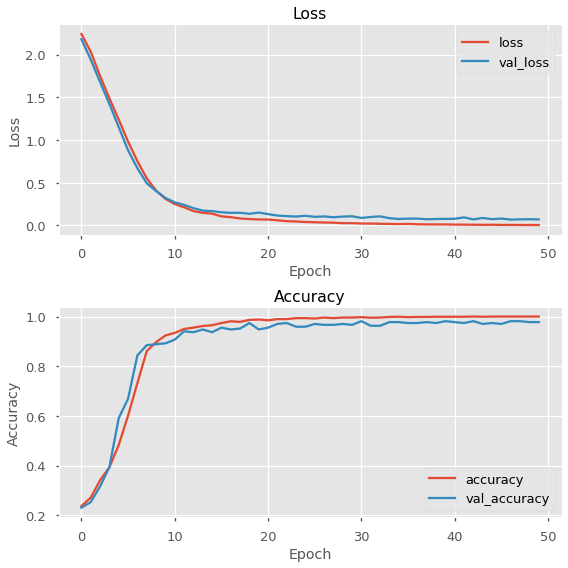

In [56]:
plot_history(history)

# Regularization

In [57]:
from tensorflow.keras import regularizers

In [58]:
# Adding a regularizer to the first hidden layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu', 
                       kernel_regularizer=regularizers.l2())) # L2 Regularizer
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                90        
Total params: 6,994
Trainable params: 6,994
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.6596 - accuracy: 0.1520 - val_loss: 2.3977 - val_accuracy: 0.2862
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.3441 - accuracy: 0.2499 - val_loss: 2.0890 - val_accuracy: 0.4610
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0777 - accuracy: 0.4153 - val_loss: 1.7747 - val_accuracy: 0.4796
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.7354 - accuracy: 0.4902 - val_loss: 1.4433 - val_accuracy: 0.5651
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.4758 - accuracy: 0.5118 - val_loss: 1.2477 - val_accuracy: 0.6320
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1492 - accuracy: 0.6692 - val_loss: 0.9195 - val_accuracy: 0.7993
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.8752 - accuracy: 0.8011 - val_loss: 0.7720 - val_accuracy: 0.8216
Epoch 8/50
40/40 [==

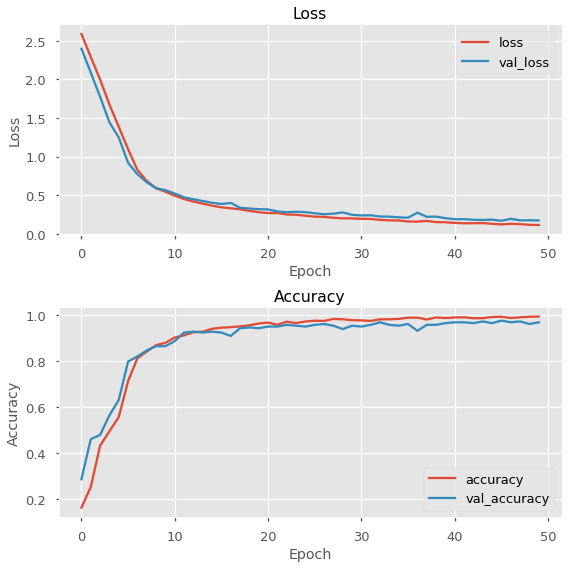

In [60]:
plot_history(history)

In [61]:
# Adding a regularizer to the each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dense(units=32, activation='relu', 
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=16, activation='relu',
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=8, activation='relu',
                       kernel_regularizer=regularizers.l2()))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.9810 - accuracy: 0.1393 - val_loss: 2.7302 - val_accuracy: 0.2862
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.6226 - accuracy: 0.3164 - val_loss: 2.3107 - val_accuracy: 0.4796
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.1983 - accuracy: 0.4989 - val_loss: 1.8261 - val_accuracy: 0.5613
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.7661 - accuracy: 0.5778 - val_loss: 1.4885 - val_accuracy: 0.6877
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.4230 - accuracy: 0.7091 - val_loss: 1.2401 - val_accuracy: 0.7472
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1654 - accuracy: 0.8076 - val_loss: 1.0787 - val_accuracy: 0.8030
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.0267 - accuracy: 0.8372 - val_loss: 0.9576 - val_accuracy: 0.8327
Epoch 8/50
40/40 [==

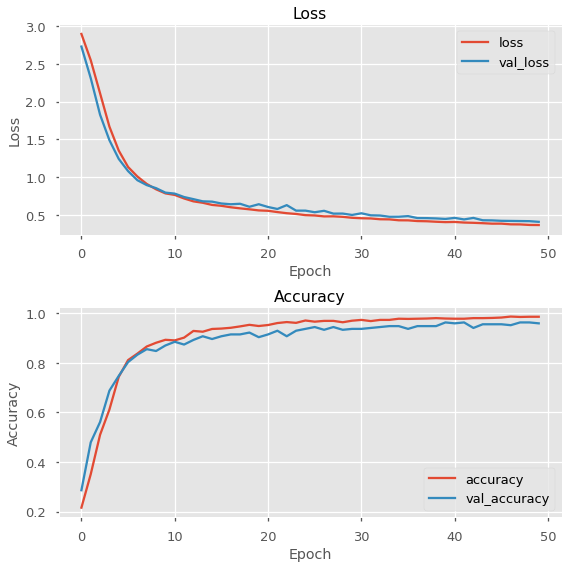

In [62]:
plot_history(history)

# Dropout
<img src='./images/drop_out.png'>

- *Adding dropout will randomly deactivate nodes during training in an attempt to strengthen and clarify the remaining active nodes.*

In [63]:
# Adding dropouts to each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.3546 - accuracy: 0.0881 - val_loss: 2.2898 - val_accuracy: 0.1227
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2874 - accuracy: 0.1082 - val_loss: 2.2783 - val_accuracy: 0.2156
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2589 - accuracy: 0.1400 - val_loss: 2.2366 - val_accuracy: 0.2825
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 2.2294 - accuracy: 0.1666 - val_loss: 2.1298 - val_accuracy: 0.3792
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 2.1704 - accuracy: 0.2077 - val_loss: 2.0115 - val_accuracy: 0.3903
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0373 - accuracy: 0.2408 - val_loss: 1.8003 - val_accuracy: 0.4498
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.9407 - accuracy: 0.2807 - val_loss: 1.5970 - val_accuracy: 0.5279
Epoch 8/50
40/40 [==

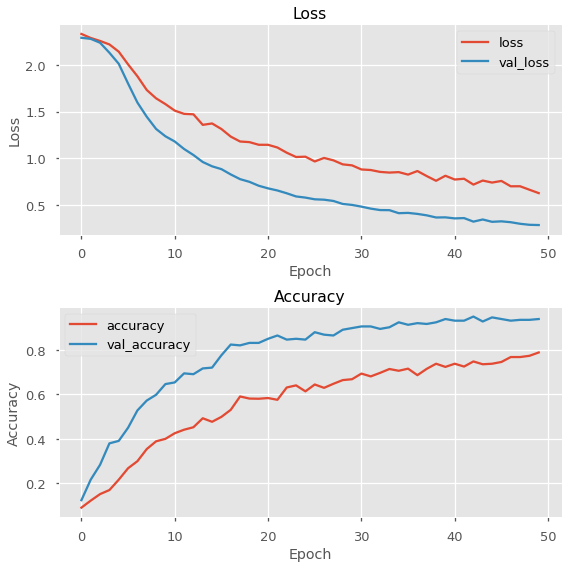

In [64]:
plot_history(history)

In [65]:
# Adding fewer dropouts to each layer.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=8, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,
    batch_size=32
    )

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 2.2790 - accuracy: 0.1226 - val_loss: 2.1484 - val_accuracy: 0.2416
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 2.0814 - accuracy: 0.2448 - val_loss: 1.8309 - val_accuracy: 0.2974
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 1.8075 - accuracy: 0.3033 - val_loss: 1.4835 - val_accuracy: 0.4015
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 1.5643 - accuracy: 0.3807 - val_loss: 1.2278 - val_accuracy: 0.5985
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 1.3324 - accuracy: 0.5338 - val_loss: 1.0234 - val_accuracy: 0.7286
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 1.1618 - accuracy: 0.5976 - val_loss: 0.8593 - val_accuracy: 0.7361
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 1.0410 - accuracy: 0.6298 - val_loss: 0.7357 - val_accuracy: 0.7918
Epoch 8/50
40/40 [==

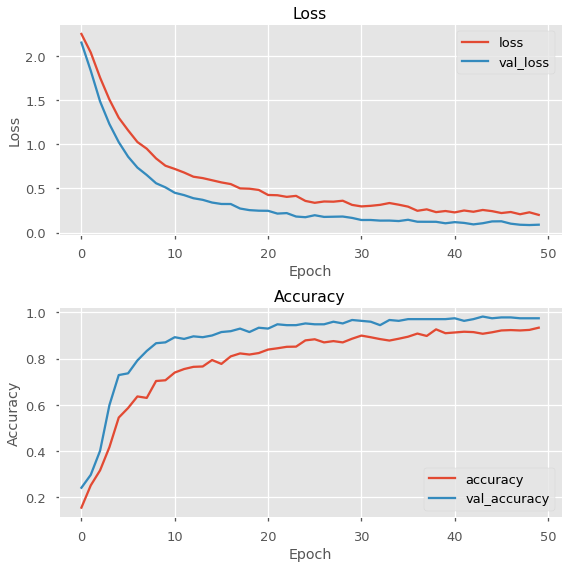

In [66]:
plot_history(history)

# Early Stopping
- *We can have the model stop training before the given number of epochs if it stops improving.*

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
# Adding EarlyStopping.
model = Sequential()
model.add(layers.Dense(units=64, activation='relu', 
                       input_dim=X_train.shape[1]))

model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dense(units=8, activation='relu'))

model.add(layers.Dense(units=10, activation='softmax'))
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]
    )

Epoch 1/200
40/40 [==============================] - 1s 6ms/step - loss: 2.2762 - accuracy: 0.1180 - val_loss: 2.1622 - val_accuracy: 0.1859
Epoch 2/200
40/40 [==============================] - 0s 2ms/step - loss: 2.0757 - accuracy: 0.2099 - val_loss: 1.8395 - val_accuracy: 0.2714
Epoch 3/200
40/40 [==============================] - 0s 2ms/step - loss: 1.7367 - accuracy: 0.3483 - val_loss: 1.4480 - val_accuracy: 0.5242
Epoch 4/200
40/40 [==============================] - 0s 2ms/step - loss: 1.3660 - accuracy: 0.5685 - val_loss: 1.0309 - val_accuracy: 0.6914
Epoch 5/200
40/40 [==============================] - 0s 2ms/step - loss: 0.9993 - accuracy: 0.6989 - val_loss: 0.7824 - val_accuracy: 0.7584
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 0.7919 - accuracy: 0.7683 - val_loss: 0.6366 - val_accuracy: 0.7955
Epoch 7/200
40/40 [==============================] - 0s 2ms/step - loss: 0.6379 - accuracy: 0.7912 - val_loss: 0.5390 - val_accuracy: 0.8178
Epoch 8/200
4

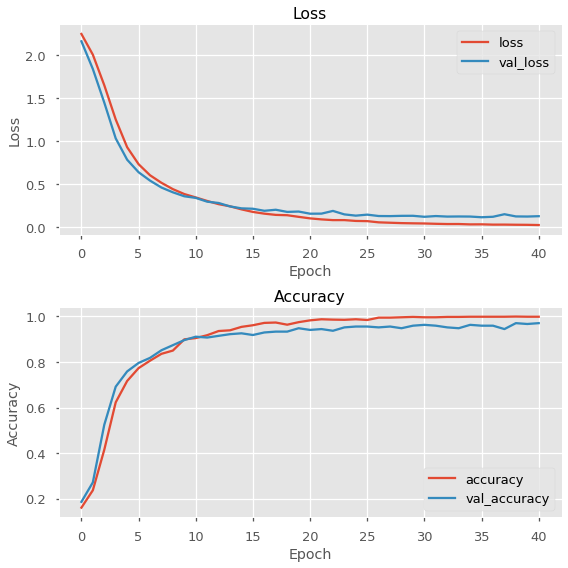

In [69]:
plot_history(history)